<a href="https://colab.research.google.com/github/farkoo/Cat-Dog-Classifier/blob/master/c-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


# Prepare train and test data (Data Preprocessing) and defien a network generator function

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash
git clone "https://github.com/MKasaei00/IUT-CI-HW3-cat-dog-classifier.git"

fatal: destination path 'IUT-CI-HW3-cat-dog-classifier' already exists and is not an empty directory.


In [ ]:
%cd IUT-CI-HW3-cat-dog-classifier

/content/drive/MyDrive/IUT-CI-HW3-cat-dog-classifier


In [ ]:
%%bash
7z x dataset/test_set.zip -odataset
7z x dataset/training_set.zip -odataset


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 3711630 bytes (3625 KiB)

Extracting archive: dataset/test_set.zip
--
Path = dataset/test_set.zip
Type = zip
Physical Size = 3711630
Embedded Stub Size = 4
Total Physical Size = 45654670
Multivolume = +
Volume Index = 2
Volumes = 3


Would you like to replace the existing file:
  Path:     dataset/test_set/cats/cat.4001.jpg
  Size:     46992 bytes (46 KiB)
  Modified: 2019-09-30 02:52:14
with the file from archive:
  Path:     test_set/cats/cat.4001.jpg
  Size:     46992 bytes (46 KiB)
  Modified: 2019-09-30 02:52:14
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 



ERROR:
Unexpected end of input stream


In [ ]:
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
from keras.utils import np_utils
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [ ]:
test_dir = 'dataset/test_set'
training_dir = 'dataset/training_set'

In [ ]:
def load_data_from_directory(dir,width,height,classes):
  img_data = []
  img_label = []
  categories = os.listdir(dir)
  for category in categories:
    for file in os.listdir(os.path.join(dir,category)):
      img_path = os.path.join(dir,category,file)
      img = cv2.imread(img_path)
      img = cv2.resize(img,(width,height))
      img = np.array(img).astype('float32') / 255
      
      img_data.append(img)
      img_label.append(category)

  img_onehot = np_utils.to_categorical([categories.index(label) for label in img_label],classes,dtype=np.ubyte)
  img_data = np.array(img_data)
  img_onehot = np.array(img_onehot)

  zip_list = list(zip(img_data, img_label, img_onehot))
  random.shuffle(zip_list)
  img_data, img_label, img_onehot = zip(*zip_list)
  return img_data , img_label, img_onehot

In [ ]:
classes = 2
w = 128
h = 128

In [ ]:
train_x , train_label, train_onehot = load_data_from_directory(training_dir,w,h,classes)
test_x , test_label, test_onehot = load_data_from_directory(test_dir,w,h,classes)

In [ ]:
test_label2 = []
for i, label in enumerate(test_label):
     test_label2.append(1) if (label == 'dogs') else test_label2.append(0)

In [ ]:
train_x = np.asarray(train_x)
train_label = np.asarray(train_label)
train_onehot = np.asarray(train_onehot)

test_x = np.asarray(test_x)
test_label = np.asarray(test_label2)
test_onehot = np.asarray(test_onehot)

In [ ]:
!rm -rf cleanData
!mkdir cleanData
np.save('cleanData/train_x.npy',train_x)
np.save('cleanData/train_label.npy',train_label)
np.save('cleanData/train_onehot.npy',train_onehot)

np.save('cleanData/test_x.npy',test_x)
np.save('cleanData/test_label.npy',test_label)
np.save('cleanData/test_onehot.npy',test_onehot)

In [ ]:
train_x = np.load('cleanData/train_x.npy')
train_label = np.load('cleanData/train_onehot.npy')

test_x = np.load('cleanData/test_x.npy')
test_label = np.load('cleanData/test_onehot.npy')
test_vec = np.load('cleanData/test_label.npy')

In [ ]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_Label, valid_Label = train_test_split(train_x, train_label, test_size = 0.2, random_state = 13)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,LeakyReLU
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.initializers import RandomNormal

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_model(config):
  model = Sequential()

  model.add(Flatten(input_shape=(h,w,3)))
  model.add(Dropout(config['in_drop_out']))

  for act ,drop_out, layers in config['layers']:
    for layer in layers:
      model.add(Dense(layer))
      model.add(act())
      model.add(Dropout(drop_out))

  model.compile(
    optimizer=Adam(config['learning_rate']),
    loss=categorical_crossentropy,
    metrics=['accuracy']
  )

  train_datagen = ImageDataGenerator(
        rotation_range=config['aug_rotation'],
        width_shift_range=config['aug_shift_w'],
        height_shift_range=config['aug_shift_h'],
        shear_range=config['aug_shear'],
        zoom_range=config['aug_zoom'],
        horizontal_flip=config['aug_horizontal_flip'],
        fill_mode='nearest'
  )

  train_generator = train_datagen.flow(train_X, train_Label, batch_size = config['batch'])

  validation_datagen = ImageDataGenerator()
  validation_generator = validation_datagen.flow(valid_X,valid_Label,batch_size=256)

  history = model.fit(train_generator,
                      validation_data=validation_generator,
                      epochs = config['epochs'],
                    )
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','validation'],loc='lower right')
  plt.show()

  test_eval = model.evaluate(test_x, test_label, verbose = 0)
  print('Test loss: ', test_eval[0])
  print('Test accuracy: ', test_eval[1])
  print('\n\n')
  
  predictes_classes = model.predict(test_x)
  predicted_classes = np.argmax(np.round(predictes_classes), axis = 1)

  from sklearn.metrics import classification_report
  target_names = ["Class {}".format(i) for i in range(classes)]
  print(classification_report(test_vec, predicted_classes, target_names = target_names))

  return model

# قسمت ج
<Div align=right>

در ادامه با ثابت ماندن پارامترهای سرعت یادگیری، درصد دراپ‌اوت نرونها در هر لایه و درصد دیتا آگمنتیشن اقدام به تغییر دادن تعداد لایه ها و نرون های شبکه عصبی کردیم و نتایج را مورد ارزیابی قرار می‌دهیم.

سپس با در نظر گرفتن پیچیدگی دیتاست و رفتار شبکه های گوناگون بهترین مدل بدست آمده را معرفی کرده و تاثیر تعداد لایه ها و نرون های موجود در هر لایه مخفی بر همگرایی و تعمیم شبکه را بیان می‌کنیم.

<div/>

# شبکه عصبی شماره 1

Epoch 1/100
25/25 [==============================] - 21s 707ms/step - loss: 0.6945 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.4888
Epoch 2/100
25/25 [==============================] - 18s 719ms/step - loss: 0.6943 - accuracy: 0.4950 - val_loss: 0.6933 - val_accuracy: 0.4888
Epoch 3/100
25/25 [==============================] - 18s 723ms/step - loss: 0.6931 - accuracy: 0.4998 - val_loss: 0.6930 - val_accuracy: 0.5113
Epoch 4/100
25/25 [==============================] - 18s 729ms/step - loss: 0.6933 - accuracy: 0.4973 - val_loss: 0.6929 - val_accuracy: 0.5081
Epoch 5/100
25/25 [==============================] - 18s 723ms/step - loss: 0.6927 - accuracy: 0.5066 - val_loss: 0.6926 - val_accuracy: 0.5119
Epoch 6/100
25/25 [==============================] - 19s 742ms/step - loss: 0.6916 - accuracy: 0.5185 - val_loss: 0.6922 - val_accuracy: 0.5213
Epoch 7/100
25/25 [==============================] - 18s 716ms/step - loss: 0.6924 - accuracy: 0.5220 - val_loss: 0.6923 - val_accuracy:

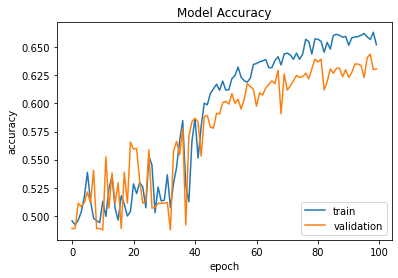

Test loss:  0.628920316696167
Test accuracy:  0.6485000252723694



              precision    recall  f1-score   support

     Class 0       0.63      0.70      0.67      1000
     Class 1       0.67      0.59      0.63      1000

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000



In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.03,[2048,1024,1024,512]+[400]*5+[300]*4+[250,200,150,120,100]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100,
    'aug_rotation':10,
    'aug_shift_w':0.04,
    'aug_shift_h':0.04,
    'aug_shear':0.04,
    'aug_zoom':0.04,
    'aug_horizontal_flip':True
})

#  شبکه عصبی شماره 2

Epoch 1/100
25/25 [==============================] - 21s 712ms/step - loss: 0.7784 - accuracy: 0.4938 - val_loss: 0.7247 - val_accuracy: 0.4888
Epoch 2/100
25/25 [==============================] - 18s 723ms/step - loss: 0.7033 - accuracy: 0.4999 - val_loss: 0.6926 - val_accuracy: 0.5319
Epoch 3/100
25/25 [==============================] - 18s 722ms/step - loss: 0.6986 - accuracy: 0.5041 - val_loss: 0.6990 - val_accuracy: 0.4888
Epoch 4/100
25/25 [==============================] - 18s 727ms/step - loss: 0.6987 - accuracy: 0.5087 - val_loss: 0.7009 - val_accuracy: 0.5113
Epoch 5/100
25/25 [==============================] - 18s 722ms/step - loss: 0.6954 - accuracy: 0.5080 - val_loss: 0.6898 - val_accuracy: 0.5125
Epoch 6/100
25/25 [==============================] - 18s 723ms/step - loss: 0.6893 - accuracy: 0.5325 - val_loss: 0.6822 - val_accuracy: 0.5619
Epoch 7/100
25/25 [==============================] - 18s 720ms/step - loss: 0.6866 - accuracy: 0.5465 - val_loss: 0.6799 - val_accuracy:

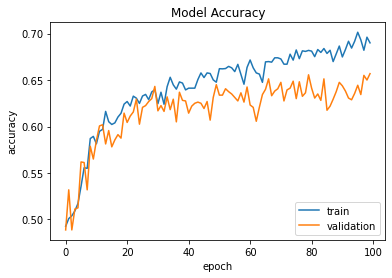

Test loss:  0.617627739906311
Test accuracy:  0.6480000019073486



              precision    recall  f1-score   support

     Class 0       0.64      0.69      0.66      1000
     Class 1       0.66      0.61      0.63      1000

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000



In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.03,[1500,1000,500]+[400]*3+[300]*2+[200,100]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100,
    'aug_rotation':10,
    'aug_shift_w':0.04,
    'aug_shift_h':0.04,
    'aug_shear':0.04,
    'aug_zoom':0.04,
    'aug_horizontal_flip':True
})

# شبکه عصبی شماره 3

Epoch 1/100
25/25 [==============================] - 18s 715ms/step - loss: 6.9160 - accuracy: 0.5027 - val_loss: 7.8777 - val_accuracy: 0.5113
Epoch 2/100
25/25 [==============================] - 18s 710ms/step - loss: 8.1752 - accuracy: 0.4928 - val_loss: 7.8777 - val_accuracy: 0.5113
Epoch 3/100
25/25 [==============================] - 18s 711ms/step - loss: 8.0226 - accuracy: 0.5023 - val_loss: 7.8777 - val_accuracy: 0.5113
Epoch 4/100
25/25 [==============================] - 18s 714ms/step - loss: 8.1721 - accuracy: 0.4930 - val_loss: 7.8777 - val_accuracy: 0.5113
Epoch 5/100
25/25 [==============================] - 18s 713ms/step - loss: 8.1002 - accuracy: 0.4974 - val_loss: 7.8777 - val_accuracy: 0.5113
Epoch 6/100
25/25 [==============================] - 18s 709ms/step - loss: 8.1385 - accuracy: 0.4951 - val_loss: 7.8777 - val_accuracy: 0.5113
Epoch 7/100
25/25 [==============================] - 18s 708ms/step - loss: 8.0048 - accuracy: 0.5034 - val_loss: 7.8777 - val_accuracy:

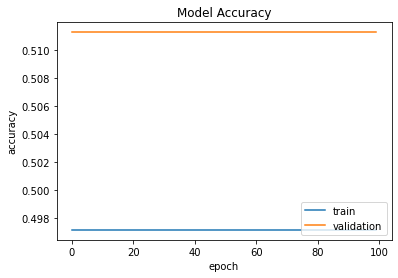

Test loss:  8.059048652648926
Test accuracy:  0.5



              precision    recall  f1-score   support

     Class 0       0.50      1.00      0.67      1000
     Class 1       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.03,[1000,500,250]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100,
    'aug_rotation':10,
    'aug_shift_w':0.04,
    'aug_shift_h':0.04,
    'aug_shear':0.04,
    'aug_zoom':0.04,
    'aug_horizontal_flip':True
})

# شبکه عصبی شماره 4

Epoch 1/100
25/25 [==============================] - 20s 740ms/step - loss: 0.6975 - accuracy: 0.4937 - val_loss: 0.6946 - val_accuracy: 0.4888
Epoch 2/100
25/25 [==============================] - 18s 734ms/step - loss: 0.6937 - accuracy: 0.5066 - val_loss: 0.6938 - val_accuracy: 0.4875
Epoch 3/100
25/25 [==============================] - 18s 733ms/step - loss: 0.6932 - accuracy: 0.5048 - val_loss: 0.6999 - val_accuracy: 0.4888
Epoch 4/100
25/25 [==============================] - 18s 732ms/step - loss: 0.6921 - accuracy: 0.5161 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 5/100
25/25 [==============================] - 18s 728ms/step - loss: 0.6897 - accuracy: 0.5344 - val_loss: 0.6886 - val_accuracy: 0.5644
Epoch 6/100
25/25 [==============================] - 18s 733ms/step - loss: 0.6926 - accuracy: 0.5262 - val_loss: 0.6907 - val_accuracy: 0.5244
Epoch 7/100
25/25 [==============================] - 18s 728ms/step - loss: 0.6912 - accuracy: 0.5247 - val_loss: 0.6929 - val_accuracy:

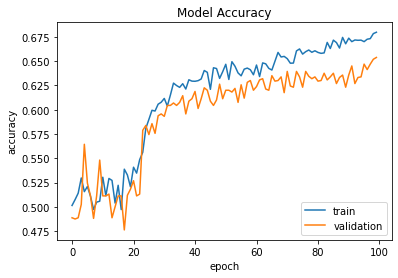

Test loss:  0.6128997802734375
Test accuracy:  0.659500002861023



              precision    recall  f1-score   support

     Class 0       0.65      0.68      0.67      1000
     Class 1       0.66      0.64      0.65      1000

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000



In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.03,[3000,2500,2000,1500,1000]+[400]*4+[400]*3+[300]*2+[250,200,150,100]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100,
    'aug_rotation':10,
    'aug_shift_w':0.04,
    'aug_shift_h':0.04,
    'aug_shear':0.04,
    'aug_zoom':0.04,
    'aug_horizontal_flip':True
})

# شبکه عصبی شماره 5


Epoch 1/100
25/25 [==============================] - 22s 796ms/step - loss: 0.6935 - accuracy: 0.5043 - val_loss: 0.6930 - val_accuracy: 0.5113
Epoch 2/100
25/25 [==============================] - 20s 785ms/step - loss: 0.6933 - accuracy: 0.4921 - val_loss: 0.6931 - val_accuracy: 0.5113
Epoch 3/100
25/25 [==============================] - 20s 794ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4888
Epoch 4/100
25/25 [==============================] - 20s 792ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4888
Epoch 5/100
25/25 [==============================] - 20s 789ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6933 - val_accuracy: 0.4888
Epoch 6/100
25/25 [==============================] - 20s 784ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6930 - val_accuracy: 0.4888
Epoch 7/100
25/25 [==============================] - 20s 785ms/step - loss: 0.6926 - accuracy: 0.5052 - val_loss: 0.6932 - val_accuracy:

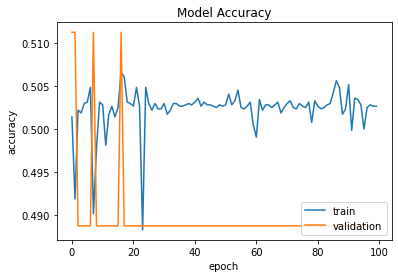

Test loss:  0.6931750774383545
Test accuracy:  0.5



              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1000
     Class 1       0.50      1.00      0.67      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.03,[8000,7000,6000,4000,3000,2000]+[1200]*5+[800]*4+[500]*3+[350]*2+[250,200,150,100,50]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100,
    'aug_rotation':10,
    'aug_shift_w':0.04,
    'aug_shift_h':0.04,
    'aug_shear':0.04,
    'aug_zoom':0.04,
    'aug_horizontal_flip':True
})

# شبکه عصبی شماره ‌6

Epoch 1/100
25/25 [==============================] - 26s 977ms/step - loss: 0.6958 - accuracy: 0.4919 - val_loss: 0.6933 - val_accuracy: 0.4969
Epoch 2/100
25/25 [==============================] - 24s 968ms/step - loss: 0.6950 - accuracy: 0.4927 - val_loss: 0.6930 - val_accuracy: 0.4988
Epoch 3/100
25/25 [==============================] - 24s 970ms/step - loss: 0.6935 - accuracy: 0.4977 - val_loss: 0.6930 - val_accuracy: 0.5138
Epoch 4/100
25/25 [==============================] - 24s 964ms/step - loss: 0.6930 - accuracy: 0.4983 - val_loss: 0.6919 - val_accuracy: 0.5075
Epoch 5/100
25/25 [==============================] - 24s 968ms/step - loss: 0.6912 - accuracy: 0.5314 - val_loss: 0.6933 - val_accuracy: 0.5031
Epoch 6/100
25/25 [==============================] - 24s 961ms/step - loss: 0.6927 - accuracy: 0.5108 - val_loss: 0.6937 - val_accuracy: 0.5125
Epoch 7/100
25/25 [==============================] - 24s 963ms/step - loss: 0.6899 - accuracy: 0.5171 - val_loss: 0.6886 - val_accuracy:

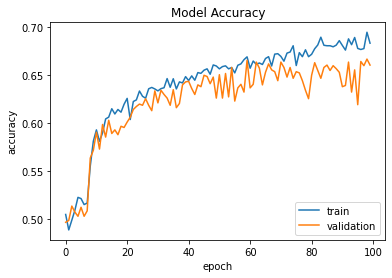

Test loss:  0.6244004368782043
Test accuracy:  0.6524999737739563



              precision    recall  f1-score   support

     Class 0       0.64      0.71      0.67      1000
     Class 1       0.67      0.59      0.63      1000

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000



In [12]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.03,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100,
    'aug_rotation':10,
    'aug_shift_w':0.04,
    'aug_shift_h':0.04,
    'aug_shear':0.04,
    'aug_zoom':0.04,
    'aug_horizontal_flip':True
})

## منظور از تعمیم پذیری یک شبکه عصبی چیست؟
<Div align=right>

هنگامی که مدلی را به وسیله ی داده ها آموزش میدهیم، پارامترهای مدل بر اساس این داده های آموزشی تنظیم میشوند، در نتیجه تعیین صحت مدل تنها به وسیله ی داده های آموزشی کار صحیحی نیست.

اگر به یک کودک تصاویری محدود از گربه نشان بدهیم و سپس در مورد نژادهای دیگری ازین جانور سوال کنیم، او به خوبی میتواند تشخیص دهد که چه پیش رو دارد و این همان چیزی است که ما از مدل انتظار داریم، میخواهیم مدل صحت مشابهی هنگام کار با داده هایی داشته باشد که آنها را ندیده است.

عوامل زیادی ممکن است باعث تعمیم ناپذیری مدل شوند اما از آنجائی که در این قسمت تعداد لایه ها و نرونهای هر لایه مورد بررسی قرار گرفته است، به بررسی همین دو پارامتر اکتفا میکنیم.

میدانیم دلیل استفاده از توابع فعال ساز غیرخطی کردن مدل است. از طرف دیگر داده های سخت نیازمند مدل های غیرخطی و داده های آسان نیازمند مدل های غیرخطی هستند.
حال فرض کنید که برای دیتاستی با داده های آسان از مدلی پیچیده و غیرخطی با درجه بالا استفاده کنیم، اتفاقی که شاهد آن هستیم حفظ شدن داده ها توسط مدل است و این گونه مدل آورفیت شده و نمیتواند عملکرد مناسبی در زمان تست داشته باشد.

تاثیر زیاد کردن لایه ها نیز مشابه با رویدادی است که در بالا شرح دادیم، با زیاد شدن نرون ها و لایه های شبکه یک مدل پیچیده پدیدآورده ایم که ممکن است باعث آورفیت شدن آن شود.

از طرف دیگر، اگر تعداد لایه ها و نرونهای آن کمتر از تعداد مورد نیاز برای بررسی دیتاست باشد مدل آندرفیت شده و در واقع نتوانسته ایم از قدرت شبکه عصبی بهره ببریم و مساله را بسیار آسان فرض کرده ایم.

<Div/>

# تحلیل شبکه های عصبی های استفاده شده

<div align=right>

در بالا با استفاده از ۶ شبکه گوناگون با استفاده از داده های آموزشی مدل خود را آموزش می دهیم

<hr>
<hr>

شبکه اول شبکه ای است با ۱۸ لایه درونی و تعداد نرونهای شبکه از ۲۰۰۰ تا آغاز شده و به ۱۰۰ نرون در لایه ی درونی آخر ختم میشود.
صحت مدل در زمان آموزش تا ۶۷ درصد دیده شده است و در زمان تست ۶۴.۸۵ درصد بوده است.

<hr>

شبکه دوم شبکه ای است با ۱۰ لایه درونی که تعداد نرون ها از ۱۵۰۰ تا در اولین لایه شروع شده و به ۱۰۰ نرون در لایه آخر ختم میشود.
در این لایه علی رغم اینکه صحت مدل در زمان تست تا ۷۰ درصد نیز بالا رفته اما در زمان تست ۶۴.۸ گزارش شده است و نتوانسته نسبت به زمان آموزش کارکرد خوبی روی داده های تست داشته باشد.

<hr>

در شبکه سوم از یک شبکه بسیار ساده سه لایه استفاده شده که تعداد نرون ها در هر لایه به ترتیب برابر با ۱۵۰۰، ۵۰۰ و ۲۵۰ تا است.
این شبکه باعث آورفیت شدن مدل روی داده ها شده است و نه در زمان تست و نه در زمان آموزش کارکرد خوبی نداشته است چرا که صحت مدل از حدود ۵۰ درصد بیشتر نشده است. گویا مدل همه ی داده ها را سگ یا گربه تشخیص میدهد و به داده ورودی توجهی ندارد.

<hr>

در شبکه چهارم از شبکه پیچیده تری استفاده کرده ایم، شبکه ای با هفده لایه درونی که تعداد نرون ها از ۳۰۰۰ نرون در لایه اول آغاز شده و در لایه ی آخر به ۱۰۰ نرون میرسد.
اگرچه صحت مدل روی داده های تست به ۶۸ درصد نیز رسیده است اما صحت مدل بر روی داده های تست به ۶۵.۹۵ درصد رسیده است که بهترین کارکرد بین مدل های ما را دارد، پس به نظر میرسد که داده های ما نیازمند شبکه ای پیچیده هستند.

<hr>

از این رو شبکه پنجم را پیچیده تر ساختیم، از ۲۵ لایه استفاده کردیم که تعداد نرون ها در لایه اول برابر با ۸۰۰۰ تاست و در لایه آخر به ۵۰ عدد میرسد.
اما خلاف انتظار ما این شبکه حتی در زمان آموزش نیز عملکرد خوبی ندارد و چه در زمان تست و چه در زمان آموزش صحتی بهتر از ۵۰ درصد بدست نمی‌آورد.
دقیقا مشابه سومین مدل که ساده ترین مدل بود این مدل نیز انگار همه داده ها را سگ یا گربه شناخته است. پس نتیجه میگیریم پیچیدگی داده ها مقداری نیست که نیاز به شبکه ای چنان پیچیده داشته باشیم.

<hr>

در نتیجه برای ساخت ششمین شبکه، شبکه چهارم که بهترین صحت را داشت کمی ساده تر میکنیم، چرا که شاید شبکه چهارم نیز بیش از اندازه پیچیده بوده است.
در این مرحله در زمان تست به صحت ۶۵.۲ میرسیم که کمتر از مدل قبلی است. پس نتیجه میگیریم که شبکه برای مدل ما بیش از اندازه ساده شده است و ساختاری مشابه با شبکه چهارم بهترین ساختار شناخته میشود.

</div>

# نتیجه‌گیری

<div dir='rtl'>

شبکه ای با ۱۷ لایه درونی که به ترتیب

* در لایه ی اول ۳۰۰۰ نرون
* در لایه ی دوم ۲۵۰۰ نرون
* در لایه ی سوم ۲۰۰۰ نرون
* در لایه چهارم ۱۰۰۰ نرون
* در لایه پنجم تا یازدهم در هر لایه ۴۰۰ نرون
* در لایه دوازدهم و سینزدهم ۳۰۰ نرون
* در لایه چهاردهم ۲۵۰ نرون
* در لایه پانزدهم ۲۰۰ نرون
* در لایه شانزدهم ۱۵۰ نرون
* در لایه هفدهم ۱۰۰ نرون

دارد بهترین همگرایی و بهترین تعمیم پذیری را داراست چرا که مشکلاتی نظیر بیش برازش را ندارد و صحت خوبی در زمان تست بدست می آورد.

</div>